<a href="https://colab.research.google.com/github/zachmurphy1/facemask-faster-rcnn/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation
This notebook displays loss plots and calculates mAP and class APs.

## Input

Trained model
```
Models/
```

Images and annotations from train, train (OS), val, and test sets
```
Train:
facemask_data/train/images
facemask_data/train/annotations

Train (OS):
facemask_data/train/oversampling/images
facemask_data/train/oversampling/annotations

Val:
facemask_data/val/images
facemask_data/val/annotations

Test:
facemask_data/test/images
facemask_data/test/annotations
```

## Output
Loss plot

PR plot

mAP

AP by class

```
Manually saved to Results/
```

# Imports

In [ ]:
# Imports
import pickle
import sys, os
import numpy as np
import pandas as pd

from PIL import Image
from bs4 import BeautifulSoup
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

     |████████████████████████████████| 686kB 22.0MB/s 
     |████████████████████████████████| 204kB 55.9MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp36-none-any.whl size=29745 sha256=94ef80bd2a81ef23e5776d8c00d7052e7491efe0f7003a84504adc30e60fe8b0
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655251 sha256=e7e8dec349bd61d88ef245343509a93288e583c1b36b7c43724308df920ed9e1
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5712 sha256=236d03db4efa4a37dac531c7d9404b6c5da1324dbaac1da46d23bf32304f72f0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


## Mount data

In [ ]:
# Mount data directory
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My\ Drive/facemask-faster-rcnn/

DATADIR = 'facemask_data'
ANNDIR = DATADIR + '/annotations'
IMGDIR = DATADIR + '/images'

SRPATH = 'sr_training/sr_model.pkl'

Mounted at /content/gdrive
/content/gdrive/My Drive/DL Final Project


## SR network architecture
Needed for importing SR network model

In [ ]:
# Set upscaling factor
sr_scale=4

class Bblock(nn.Module):
  def __init__(self):
    super(Bblock,self).__init__()

    self.conv1 = nn.Conv2d(64,64,(3,3),stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.prelu = nn.PReLU(64)
    self.conv2 = nn.Conv2d(64,64,(3,3),stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    
  def forward(self, x):
    skip = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.prelu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = out + skip
    return out


class Upscale(nn.Module):
  def __init__(self):
    super(Upscale,self).__init__()
    self.conv1 = nn.Conv2d(64,256,(3,3),stride=1,padding=1)
    self.pixelShuffle = nn.PixelShuffle(2)
    self.prelu = nn.PReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.pixelShuffle(out)
    out = self.prelu(out)
    return out

class SRNetwork(nn.Module):
  def __init__(self):
    super(SRNetwork,self).__init__()
    self.conv1 = nn.Conv2d(3,64,(9,9),stride=1,padding=4)
    self.prelu = nn.PReLU()

    bres_modules = []
    for i in range(16):
      bres_modules.append(Bblock())
    self.Bres = nn.Sequential(*bres_modules)

    self.conv2 = nn.Conv2d(64,64,(3,3),stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    self.upscale1 = Upscale()
    self.upscale2 = Upscale()

    self.conv3 = nn.Conv2d(64,3,(9,9),stride=1,padding=4)


  def forward(self, x):
    out = self.conv1(x)
    out = self.prelu(out)
    skip = out
    out = self.Bres(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = out + skip

    out = self.upscale1(out)
    out = self.upscale2(out)

    out = self.conv3(out)
    return out


## Dataset class

In [ ]:
class MaskDataset(Dataset):
  def __init__(self, op='train', sr=False, do_transforms=True):
    # Set data dir based on op
    self.op = op
    if self.op in ['train', 'val', 'test', 'train/oversampling']:
      # Get data dirs and metadata
      self.data_dir = DATADIR + '/' + self.op
      self.ann_dir = os.path.join(self.data_dir,'annotations')
      self.img_dir = os.path.join(self.data_dir,'images')

      self.files = next(os.walk(self.img_dir))[2]
      self.n = len(self.files)
      self.do_transforms=do_transforms

      # Get instance counts by class
      # For each image
      counts = {'no_mask':0,
                'masked':0,
                'incorrect':0}
      for i in range(self.n):
        # Get annotations
        ann_path = self.ann_dir + '/' + str(i) + '.xml'
        with open(ann_path, 'r') as f:
          ann_xml = f.read()
        ann_parsed = BeautifulSoup(ann_xml,'lxml')
        objects = ann_parsed.find_all('object')
        n_objs = len(objects)

        for o in objects:
          # Get target path
          mask_class = o.find('name').text.strip()
          prefix = ''
          if mask_class == 'without_mask':
            prefix = 'no_mask'
          elif mask_class == 'with_mask':
            prefix = 'masked'
          elif mask_class == 'mask_weared_incorrect':
            prefix = 'incorrect'
          else:
            print('mask label error')
          # Increment count
          counts[prefix] += 1
      self.counts = counts
      
    else:
      print('op should be train, val, or test')

    # Set SR conditions
    self.sr = sr
    if self.sr:
      with open(SRPATH, 'rb') as f:
        self.sr_model = pickle.load(f)

  def __len__(self):
        return self.n

  def __getitem__(self, idx):
    # Get image
    img_path = self.img_dir + '/' + self.files[idx][:-4] + '.png'
    img = Image.open(img_path).convert('RGB')
    
    # Get annotations
    ann_path = self.ann_dir + '/' + self.files[idx][:-4]  + '.xml'
    with open(ann_path) as f:
      ann_xml = f.read()
      ann_parsed = BeautifulSoup(ann_xml,'xml')
      objects = ann_parsed.find_all('object')
    n_objs = len(objects)

    # Get ground truth bboxes and labels
    def getBbox(obj):
      return [int(o.find('xmin').text),int(o.find('ymin').text),int(o.find('xmax').text),int(o.find('ymax').text)]
    
    def getLabel(obj):
      label = obj.find('name').text.strip()
      if label == 'without_mask':
        return 1
      elif label == 'with_mask':
        return 2
      elif label == 'mask_weared_incorrect':
        return 3
      else:
        raise Exception("Unknown label '{}'".format(label))

    def getSize(obj):
      size_xml = obj.parent.find('size')
      width = int(size_xml.find('width').text)
      height = int(size_xml.find('height').text)
      return [width,height]
    
    bboxes = []
    labels = []
    size = []
    for o in objects:
      bboxes.append(getBbox(o))
      labels.append(getLabel(o))
      size.append(getSize(o))
    
    # Combine annotations into tensor dict
    ann = {
        'boxes': torch.as_tensor(bboxes),
        'labels': torch.as_tensor(labels),
        'image_id': torch.as_tensor([idx]),
        'size': torch.as_tensor(size)
    }

    # To tensor
    to_tensor = transforms.ToTensor()
    img = to_tensor(img)

    # SR
    if self.sr:
      with torch.no_grad():
        if torch.cuda.is_available():
          img = img.cuda()
        img = self.sr_model(img.unsqueeze(0))
        img = img[0]
        img = img.cpu()

      for b in range(len(ann['boxes'])):
        ann['boxes'][b] = ann['boxes'][b]*sr_scale
      ann['size'] = ann['size']*sr_scale


    # Transforms if train
    if self.do_transforms:
      if self.op=='train':
        # Color jitter
        cj = torchvision.transforms.ColorJitter()
        img = cj(img)

        # Random horiz flip
        if np.random.choice([True,False]):
          img = torch.flip(img,[2])
          for b in range(len(ann['boxes'])):
            width = ann['size'][b][0].item()
            xmin = ann['boxes'][b][0].item()
            ymin = ann['boxes'][b][1].item()
            xmax = ann['boxes'][b][2].item()
            ymax = ann['boxes'][b][3].item()

            ann['boxes'][b][0] = torch.Tensor([width - xmax])
            ann['boxes'][b][1] = torch.Tensor([ymin])
            ann['boxes'][b][2] = torch.Tensor([width - xmin])
            ann['boxes'][b][3] = torch.Tensor([ymax])

    # Return image and target
    return img, ann

# mAP and AP function

In [ ]:
def getmAP(model,dataLoader,n_classes, mode='PASCAL_VOC_NEW', showPlots=True, class_labels=['No mask', 'Masked', 'Incorrect mask']):
  with torch.no_grad():
    preds_list = []
    gt_list = []
    # For each batch
    counter = 0
    gt_counts = {}
    for c in range(1,n_classes+1):
      gt_counts.update({c:0})

    for imgs, anns in dataLoader:
      counter += 1
      # Put on cuda if available
      if torch.cuda.is_available():
        imgs = list(i.cuda() for i in imgs)
        anns = [{k:v.cuda() for k,v in a.items()} for a in anns]

      # Get predictions
      model.eval()
      preds = model(imgs)

      # For each image
      for i in range(len(imgs)):
        pred = preds[i]
        ann = anns[i]

        image_id = ann['image_id']

        # Put ann into list of dicts
        ann_dict = []
        for g in range(len(ann['boxes'])):
          ad = {
              'box': ann['boxes'][g],
              'label': ann['labels'][g],
              'image_id': image_id,
              'used': False
          }
          gt_counts[ad['label'].item()] += 1
          ann_dict.append(ad)

        # Put preds into list of dicts
        pred_dict = []
        for p in range(len(pred['boxes'])):
          pdi = {
              'box': pred['boxes'][p],
              'label': pred['labels'][p],
              'score': pred['scores'][p],
              'image_id': image_id,
              'gt': None,
              'gt_label': None,
              'iou': None
          }

          # Find matching gt
          candidate_ious = []
          candidate_idxs = []
          # For each gt box
          for g_idx in range(len(ann_dict)):
            g = ann_dict[g_idx]
            # If gt box has not yet been used, get iou with pred box and append to candidates
            if g['used'] == False:
              iou = torchvision.ops.box_iou(pdi['box'].unsqueeze(0),g['box'].unsqueeze(0))
              candidate_ious.append(iou)
              candidate_idxs.append(g_idx)

          if len(candidate_ious) > 0:
            # Get best iou and index
            iou_argmax = np.argmax(candidate_ious)
            idx_max = candidate_idxs[iou_argmax]
            iou_max = candidate_ious[iou_argmax]

            # Declare match, set gt box as used
            pdi.update({'gt':idx_max})
            pdi.update({'gt_label':ann_dict[idx_max]['label']})
            pdi.update({'iou':iou_max})
            ann_dict[idx_max]['used'] = True

          pred_dict.append(pdi)
        # Append to collectors
        preds_list = preds_list + pred_dict
        gt_list = gt_list + ann_dict

    # Convert to np array
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width',1000)
    preds_array = []
    for p in preds_list:
      label = p['label'].item()
      score = p['score'].item()
      image_id = p['image_id'][0].item()
      gt = p['gt']
      gt_label = p['gt_label'].item() if p['gt_label'] else np.nan
      iou = p['iou'][0].item() if p['iou'] else np.nan

      pred = [label, score, image_id, gt, gt_label, iou, label==gt_label]
      preds_array.append(pred)

    preds_df = pd.DataFrame(preds_array)
    preds_df.columns = ['label', 'score', 'image_id', 'gt', 'gt_label', 'iou', 'TP']

    # For each threshold
    def getPRforIOUthresh(iou_threshold=0.5):
      # For each class
      class_container = {}
      confusion_matrix = []
      for c in range(1,n_classes+1):
        preds_df_cls = preds_df[preds_df['label'] == c].sort_values('score', ascending=False)

        # Get n of gt
        ngt = gt_counts[c]

        # Run down each row with iou >= iou_threshold
        precision = []
        recall = []
        preds_df_cls_iou = preds_df_cls[preds_df_cls['iou'] >= iou_threshold]

        # Total TP, FP, FN
        n_tp = preds_df_cls_iou['TP'].sum()
        n_fp = preds_df_cls_iou.shape[0] - n_tp
        n_fn = ngt - n_tp
        print(class_labels[c-1], '#TP:', n_tp, '#FP:',n_fp, '#FN:', n_fn)

        for i in range(preds_df_cls_iou.shape[0]):
          n_tp = preds_df_cls_iou['TP'][:i+1].sum()
          precision.append(n_tp / (i+1))
          recall.append(n_tp / ngt)

          # Confusion matrix
          

        if preds_df_cls_iou.shape[0] == 0:
          precision.append(0)
          recall.append(0)

        class_container.update({c:{'precision':precision, 'recall':recall}})
      return class_container
    
    # Specific mode
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    if mode == 'PASCAL_VOC_NEW':
      pr = getPRforIOUthresh(0.5)
      APs = []
      fig, ax = plt.subplots(1,1)
      for c in range(1,n_classes+1):
        precision = pr[c]['precision']
        recall = pr[c]['recall']

        # Right max precision and AUC
        auc = 0
        precision_interp = precision.copy()
        for i in range(len(precision_interp)-1):
          precision_interp[i] = np.max(precision_interp[i+1:])
          auc += (recall[i+1]-recall[i])*precision_interp[i+1]
        APs.append(auc)

        ax.plot(recall,precision,linestyle='--', color=colors[(c-1)%len(colors)], label=None)
        ax.step(recall,precision_interp,linestyle='-', color=colors[(c-1)%len(colors)],where='post', label=class_labels[c-1])

      if showPlots:
        plt.title('AP by class')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        ax.add_patch(patches.Rectangle((0,0),1,1,linewidth=0.5,zorder=-1,edgecolor='black',fill=False))
        plt.legend()
        plt.show()

      # Return mAP
      print(APs)  
      mAP = np.average(APs,weights = [v for k,v in dataLoader.dataset.counts.items()]/np.sum([v for k,v in dataLoader.dataset.counts.items()]))
      print('mAP:',mAP)
      return mAP

In [ ]:
def evalModel(model,dataLoader):
  with torch.no_grad():
    total_loss = 0
    for img, ann in dataLoader:
      # Put on cuda if available
      if torch.cuda.is_available():
        img = list(i.cuda() for i in img)
        ann = [{k:v.cuda() for k,v in a.items()} for a in ann]

      # Get loss, add to loss container for minibatch train loss
      loss = model(img,ann)
      loss_sum = sum(l for l in loss.values())
      total_loss += loss_sum.item()
    return total_loss/len(dataLoader)

## Training class

In [ ]:
class TrainingModel():
  def collate_fn(self,batch):
      return tuple(zip(*batch))
      
  def __init__(self, model, batch_size, max_epochs, optimizer, 
               performTesting,print_every,saveFile):
    self.model = model
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.optimizer = optimizer
    self.performTesting = performTesting
    self.print_every = print_every
    self.saveFile = DATADIR[:DATADIR.rfind('/')] + '/Models/' + saveFile + '.pkl'
    self.losses = {'train':[], 'val':[], 'test':[]}
    self.minibatch_losses = []
    self.epoch = 0

    self.trainLoader = DataLoader(trainData, batch_size=self.batch_size, pin_memory=True, shuffle=True, collate_fn=self.collate_fn)
    self.valLoader = DataLoader(valData, batch_size=self.batch_size, pin_memory=True, shuffle=True, collate_fn=self.collate_fn)
    self.testLoader = DataLoader(testData, batch_size=self.batch_size, pin_memory=True, shuffle=True, collate_fn=self.collate_fn)

  def save(self):
    # Save
    with open(self.saveFile, 'wb') as f:
      pickle.dump(self, f)

  def load(file):
    # Load
    with open(DATADIR[:DATADIR.rfind('/')] + '/Models/' + file + '.pkl', 'rb') as f:
      tm = pickle.load(f)
    return tm

  def train(self):
    # Get if cuda is available
    cuda_available = torch.cuda.is_available()

    # Put model on cuda
    if cuda_available:
      self.model = self.model.cuda()

    # For each epoch
    self.model.train()
    print('starting training...')
    for epoch in range(self.epoch,self.max_epochs,1):
      self.epoch = epoch
      # For each batch
      batch_count = 0
      for img, ann in self.trainLoader:
        # Put on cuda if available
        if cuda_available:
          img = list(i.cuda() for i in img)
          ann = [{k:v.cuda() for k,v in a.items()} for a in ann]

        # Get loss, add to loss container for minibatch train loss
        loss = self.model(img, ann)
        loss_sum = sum(l for l in loss.values())
        self.minibatch_losses.append(loss_sum.item())

        # Update status
        batch_count += 1
        sys.stdout.write('\rEpoch {} (Batch {}/{}) Loss: {:.8f}'.format(epoch,batch_count,len(self.trainLoader), loss_sum))
        sys.stdout.flush()

        # Backprop
        self.optimizer.zero_grad()
        loss_sum.backward()
        self.optimizer.step()

      # Evaluate, print, and save periodically
      with torch.no_grad():
        if epoch % self.print_every == 0:
          # Get val loss, append to container
          self.losses['train'].append(np.sum(self.minibatch_losses[-len(self.trainLoader):])/len(self.trainLoader))
          self.losses['val'].append(evalModel(self.model,self.valLoader))

          # If testing, get testing loss and append to container
          if self.performTesting:
            self.losses['test'].append(evalModel(self.model,self.testLoader))
          
          # Print
          if self.performTesting:
            print('Epoch {}:\tTrain loss: {:.4f}\tVal loss: {:.4f}\tTest loss: {:.4f}'.format(epoch, self.losses['train'][-1], self.losses['val'][-1], self.losses['test'][-1]))
          else:
            print('Epoch {}:\tTrain loss: {:.4f}\tVal loss: {:.4f}'.format(epoch, self.losses['train'][-1], self.losses['val'][-1]))

          # Save
          self.save()

## Load model

In [ ]:
# Load
fasterRCNN = TrainingModel.load('final_os_sr')

# Loss plots

In [ ]:
def plotLoss(trainingModel):
  plt.plot(trainingModel.losses['train'])
  plt.plot(trainingModel.losses['val'])
  legend = ['Train', 'Val']
  if trainingModel.performTesting:
    plt.plot(trainingModel.losses['test'])
    legend = legend + ['Test']
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(legend)
  plt.show()

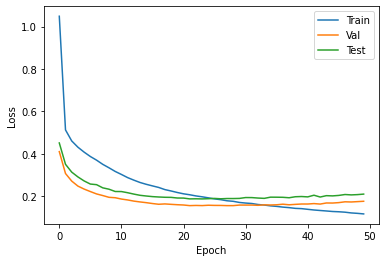

In [ ]:
plotLoss(fasterRCNN)

# Display

In [ ]:
mask_labels = {1:'no mask', 2:'masked', 3:'worn incorrectly'}

def display(model, img, gt=None, show_pred=True, show_ground_truth=True, score_threshold=0.8):
  def rectangle(x0,x1,y0,y1, edgestyle='-', color='r',linewidth=1, fillcolor='none'):
    return patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=linewidth,edgecolor=color,linestyle=edgestyle,facecolor=fillcolor)

  def drawAnn(ax,bbox,label,kind):
    # Colors
    colors = {'gt':'red','pred':'green','no mask':'red','masked':'green','worn incorrectly':'orange'}
    col = colors[kind]

    # Add rectangle
    bb = rectangle(bbox[0], bbox[2], bbox[1], bbox[3], color=col)
    ax.add_patch(bb)

    # Add annotation
    ax.text(bbox[0]+2, bbox[1]-3, label, 
              fontsize=10, fontdict={'family': 'monospace'}, 
              bbox=dict(facecolor=col, alpha=1,edgecolor=col,pad=2))

  fig, ax = plt.subplots(1,1, figsize=(10,10))
  ax.imshow(torch.clip(torch.transpose(torch.transpose(img,0,2),0,1)),0,1)

  # Ground truth annotation
  if show_ground_truth and gt != None:
    num_objects = len(ann['boxes'])
    for b in range(num_objects):

      # Get bbox
      bbox = [x.item() for x in ann['boxes'][b]]

      # Add label
      label = mask_labels[ann['labels'][b].item()] + ' (GT)'
      
      # Draw annotation
      drawAnn(ax,bbox,label,kind='gt')
      
  # Prediction annotation
  if show_pred:
    # Get predictions
    model.eval()
    if torch.cuda.is_available():
      img = img.cuda()
    pred = model(img.unsqueeze(0))

    # Show annotations
    pred = pred[0]
    num_objects = pred['boxes'].shape[0]
    for b in range(len(pred['boxes'])):
      if pred['scores'][b] >= score_threshold:
        # Get bbox
        bbox = [x.item() for x in pred['boxes'][b]]

        # Add label
        label = mask_labels[pred['labels'][b].item()] + ' ({:.2f})'.format(pred['scores'][b])
        
        # Draw annotation
        if show_ground_truth:
          drawAnn(ax,bbox,label,kind='pred')
        else:
          drawAnn(ax,bbox,label,kind=mask_labels[pred['labels'][b].item()])
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


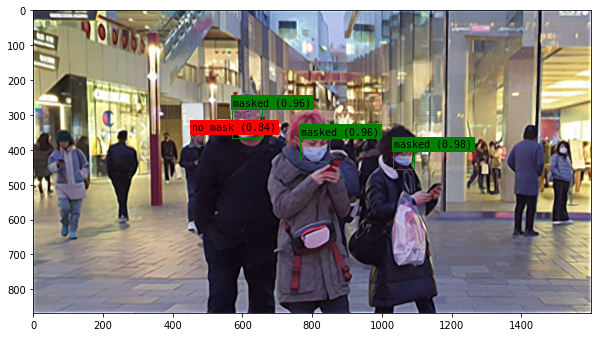

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


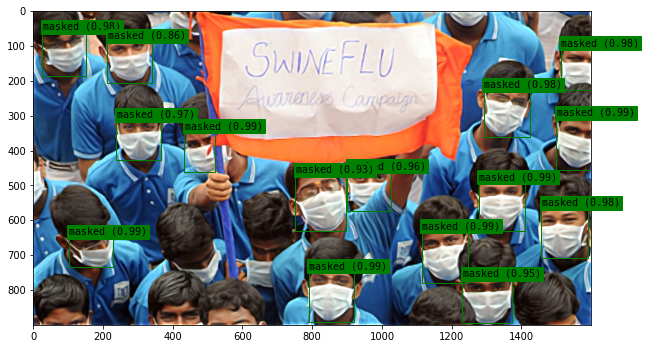

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


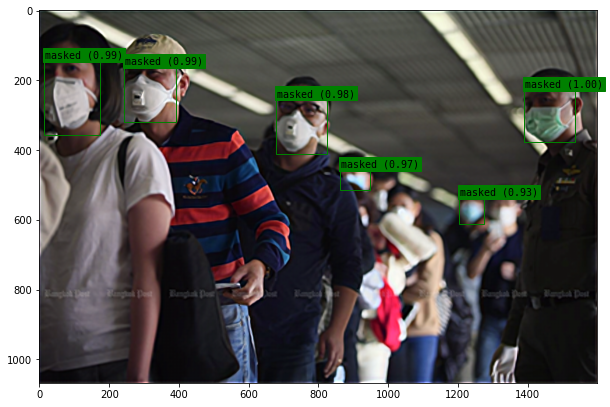

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


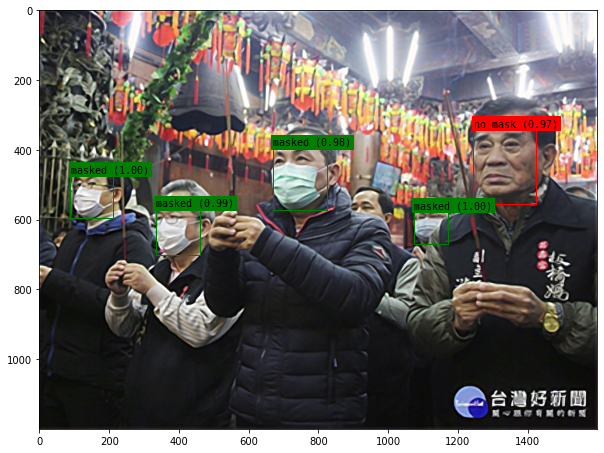

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


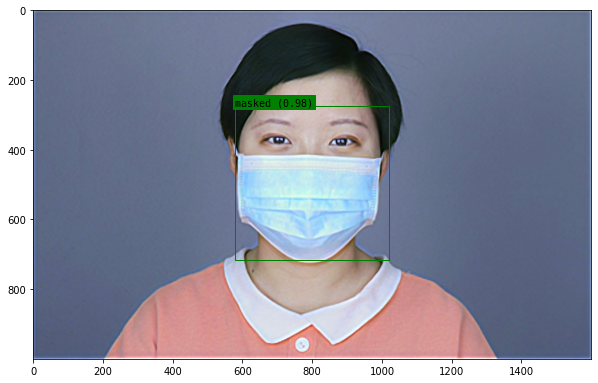

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


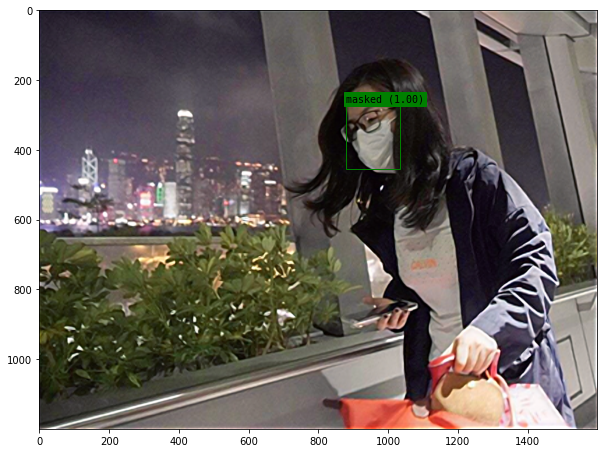

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


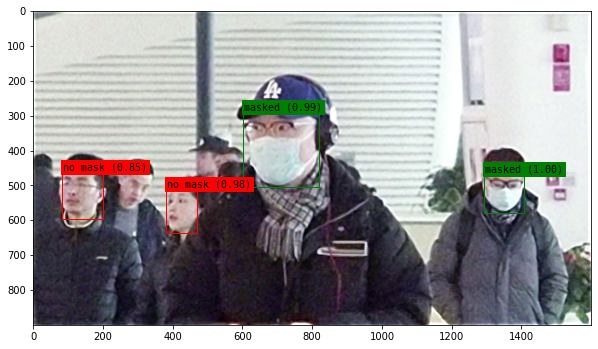

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


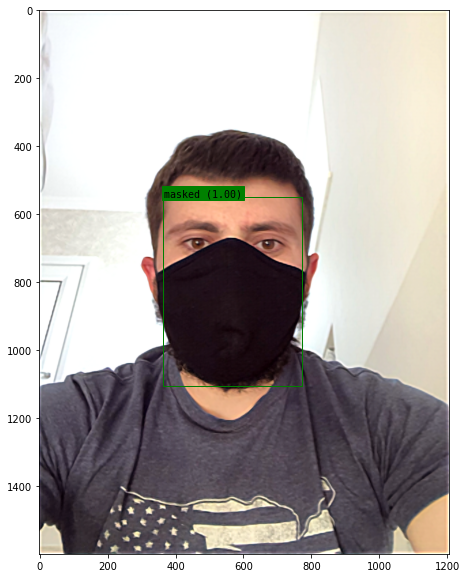

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


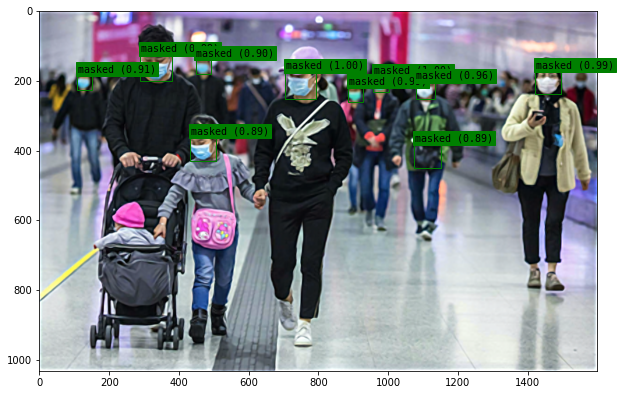

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


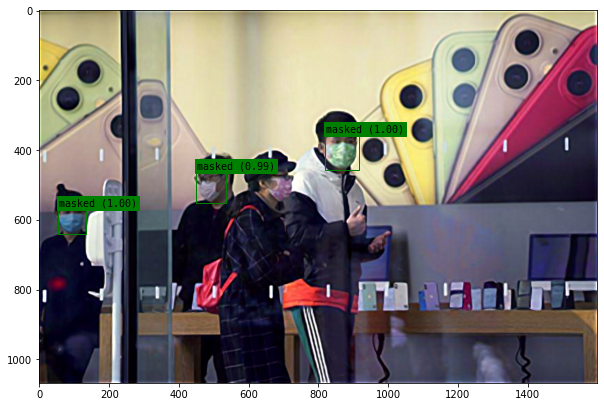

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


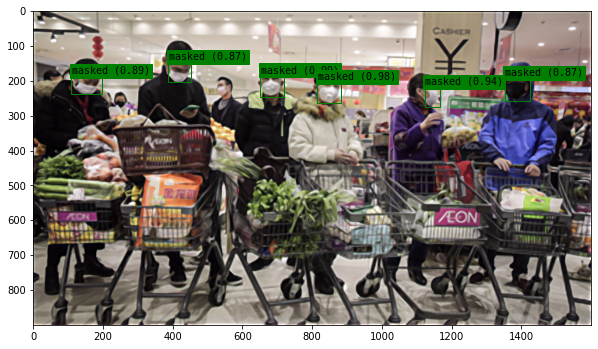

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


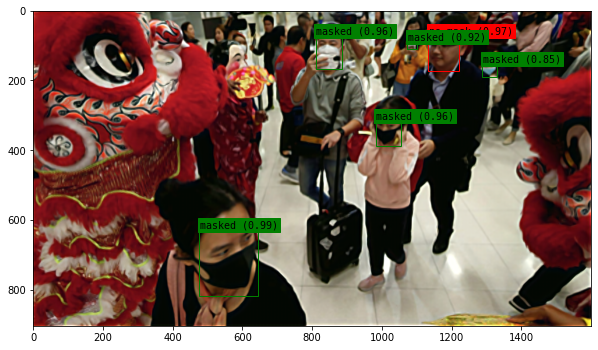

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


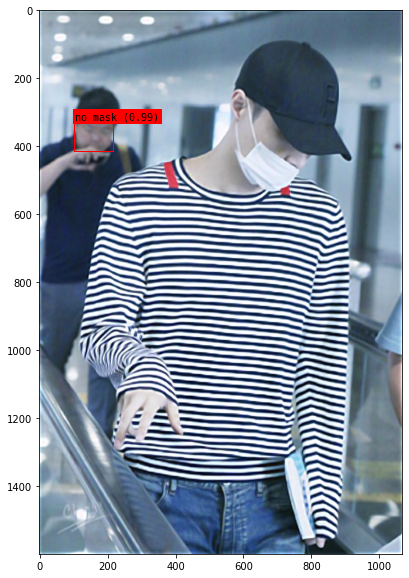

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


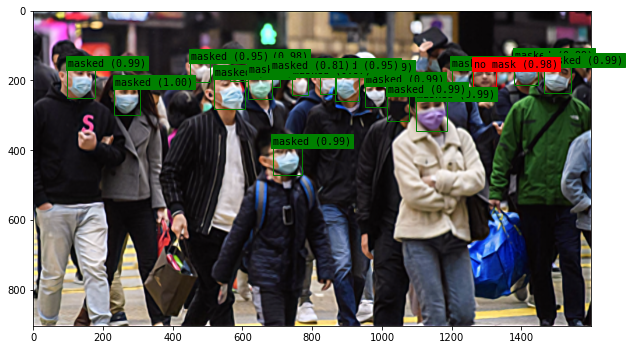

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


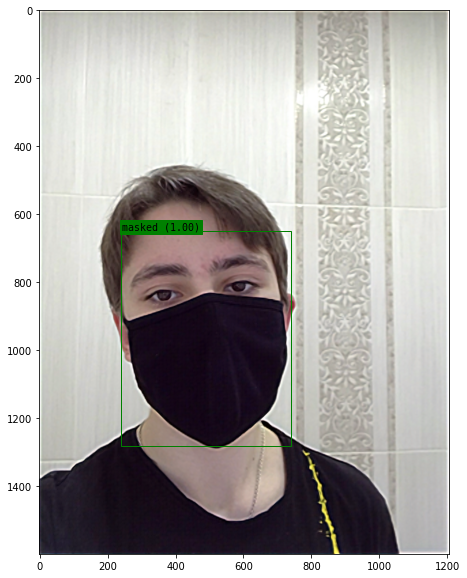

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


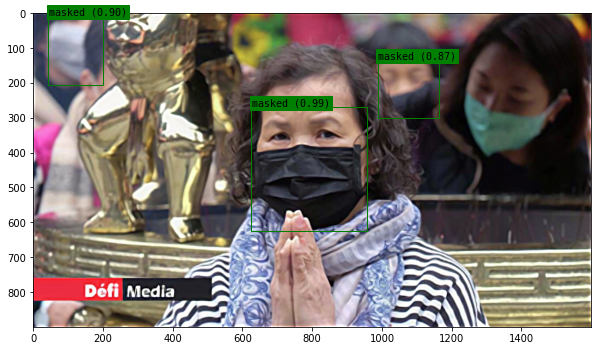

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


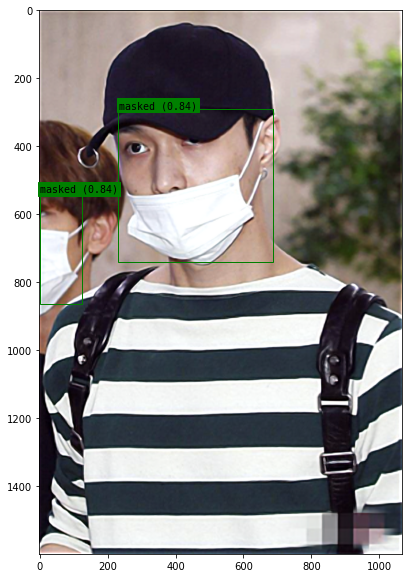

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


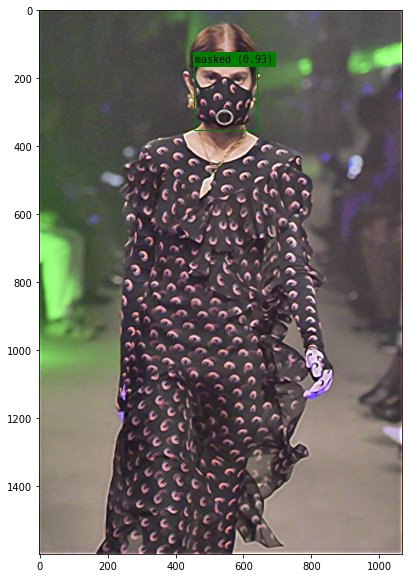

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


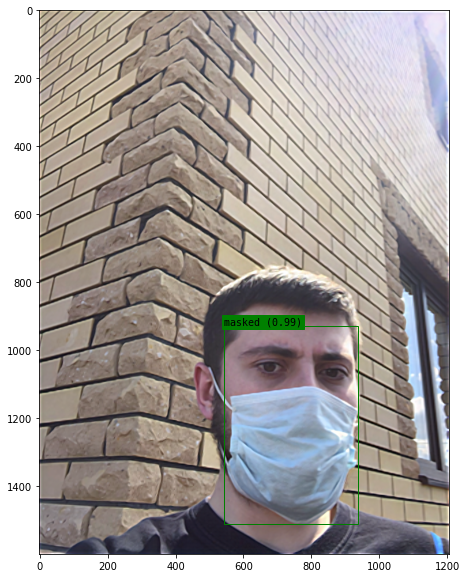

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


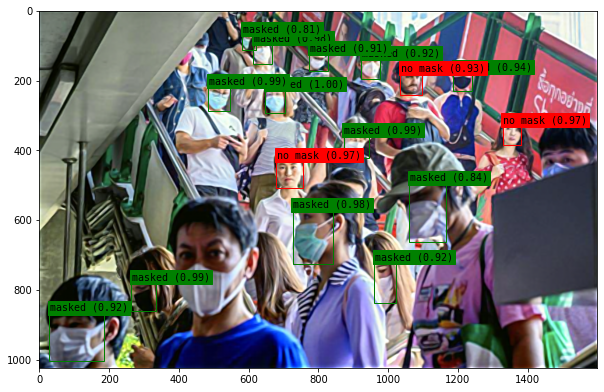

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


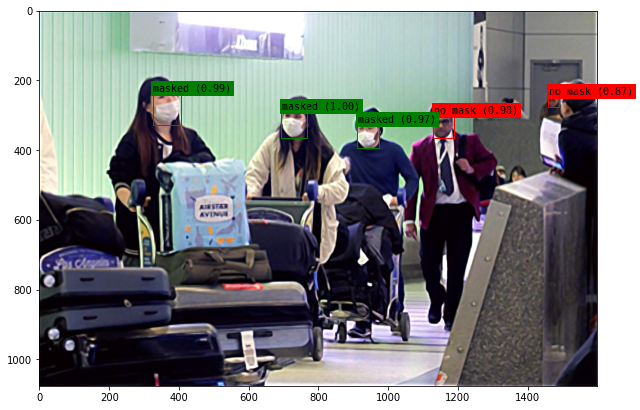

IndexError: ignored

In [ ]:
s=150
for i in range(s,s+50):
  img, ann = fasterRCNN.testLoader.dataset[i]
  display(fasterRCNN.model, img, gt=ann, show_pred=True,show_ground_truth=False)

Train:
No mask #TP: 352 #FP: 23 #FN: 109
Masked #TP: 1714 #FP: 59 #FN: 148
Incorrect mask #TP: 0 #FP: 0 #FN: 66


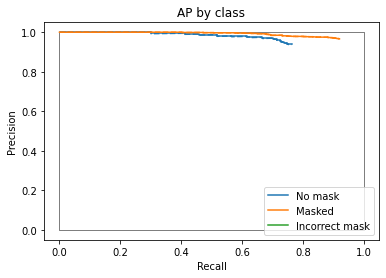

[0.7521326021961068, 0.9138452838276078, 0]
mAP: 0.8573934902048602
Val:
No mask #TP: 77 #FP: 8 #FN: 40
Masked #TP: 557 #FP: 22 #FN: 57
Incorrect mask #TP: 0 #FP: 0 #FN: 30


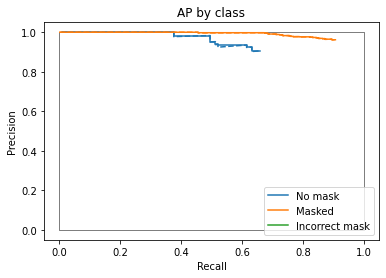

[0.6356593298427805, 0.8997658175295912, 0]
mAP: 0.8236903463269045
Test:
No mask #TP: 104 #FP: 8 #FN: 35
Masked #TP: 678 #FP: 22 #FN: 78
Incorrect mask #TP: 0 #FP: 0 #FN: 27


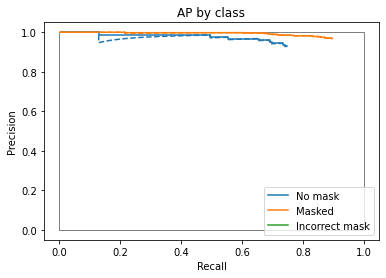

[0.7219459443328896, 0.8898976018122967, 0]
mAP: 0.8385174330069066


In [ ]:
print('Train:')
mAP = getmAP(fasterRCNN.model, fasterRCNN.trainLoader, n_classes=3)
print('Val:')
mAP = getmAP(fasterRCNN.model, fasterRCNN.valLoader, n_classes=3)
if fasterRCNN.performTesting:
  print('Test:')
  mAP = getmAP(fasterRCNN.model, fasterRCNN.testLoader, n_classes=3)